## Diamond prices

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from module import *  # in-house module

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## Load main dataset
df = sns.load_dataset('diamonds')
df = df[['price','carat','color','cut','clarity']]
errors = pd.DataFrame()  # used to store errors for plotting

## Project-wide toggles
intercept = True  # intercept for OLS models
scoring = 'neg_mean_absolute_error'  # scoring method for cross-validation


def get_errors(data, model, exog, endog):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1996)
    errors = pd.DataFrame()

    # yield cv errors
    for tr, tt in kfold.split(data):
        xtr, ytr = data.iloc[tr][exog], data.iloc[tr][endog]
        xtt, ytt = data.iloc[tt][exog], data.iloc[tt][endog]
        model.fit(xtr, ytr)

        ypred = model.predict(xtt).reshape(-1,1)
        errors = errors.append(abs(ypred - ytt), ignore_index=True)

    return errors.replace([-np.inf, np.inf], np.nan)

<AxesSubplot:xlabel='carat', ylabel='price'>

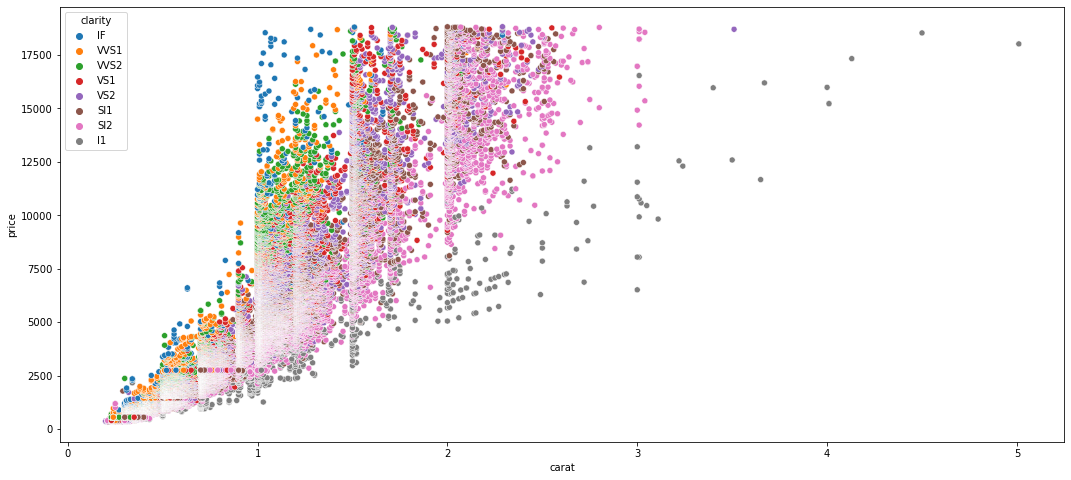

In [89]:
fig, ax = plt.subplots(1,1,figsize=(18,8))

sns.scatterplot(x='carat', y='price', hue='clarity', cmap='viridis', data=df).set_title('Basic data exploration')

In [90]:
## Basic regression: price ~ b1*carat + e

y = ['price']
X = ['carat']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept = intercept))
])

cross_val_score(estimator=pipe,
                X = df[X],
                y = df[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-1007.5660222146155

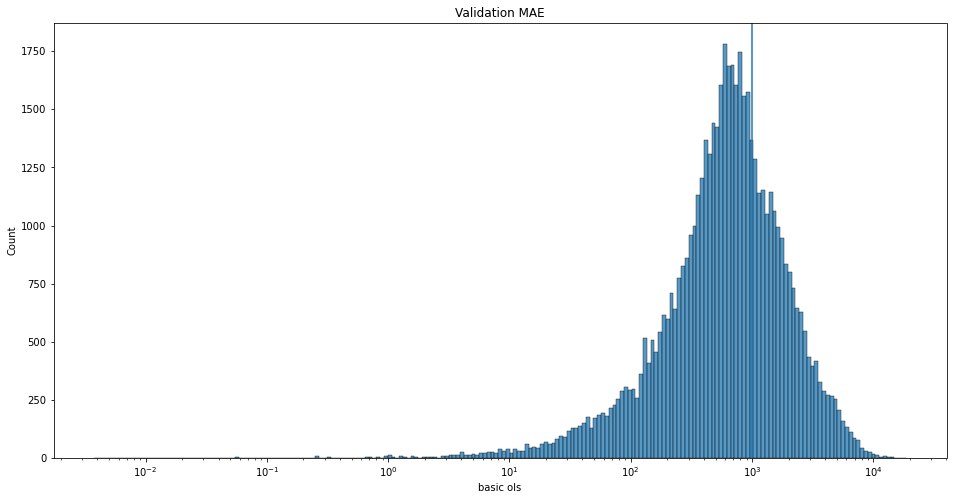

In [91]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['basic ols'] = get_errors(data=df, model=pipe, exog=X, endog=y)
sns.histplot(errors['basic ols'], log_scale=True, ax=ax).set_title('Validation MAE')
ax.axvline(x=errors['basic ols'].mean(), c='C0')

In [92]:
## Allow prices to be quadratic in carats: price ~ b0 + b1*carat * b2*carat^2 + e

df['carat^2'] = df.carat**2

y = ['price']
X = ['carat','carat^2']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept = intercept))
])

cross_val_score(estimator = pipe,
                X = df[X],
                y = df[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-953.9766820568611

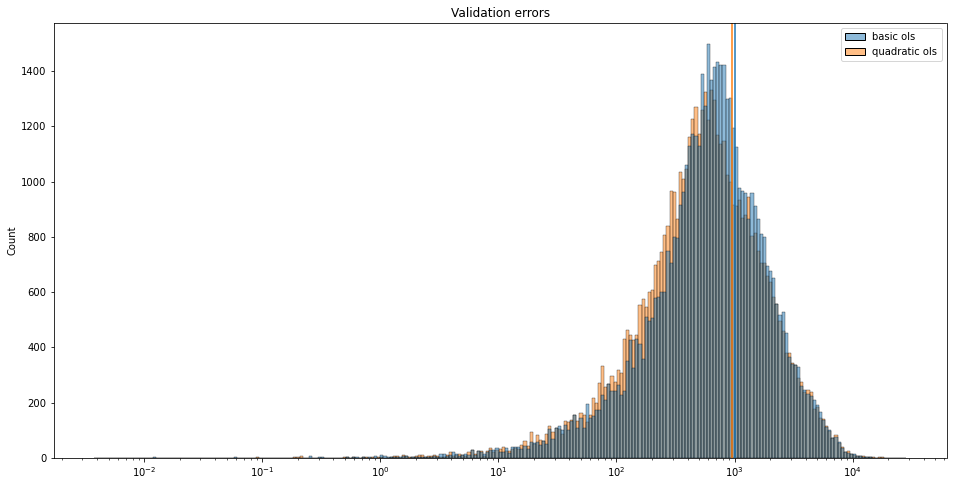

In [93]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['quadratic ols'] = get_errors(data=df, model=pipe, exog=X, endog=y)
sns.histplot(errors, log_scale=True, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')

In [94]:
## Regression with dummies for categories: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies = df.drop(['cut','color','clarity'], axis='columns')\
    .join(pd.get_dummies(df.cut, drop_first=True))\
    .join(pd.get_dummies(df.color, drop_first=True))\
    .join(pd.get_dummies(df.clarity, drop_first=True))

y = ['price']
X = [col for col in df_dummies.columns if col != y[0]]

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=intercept))
])

cross_val_score(estimator = pipe,
                X = df_dummies[X],
                y = df_dummies[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-773.0550338559972

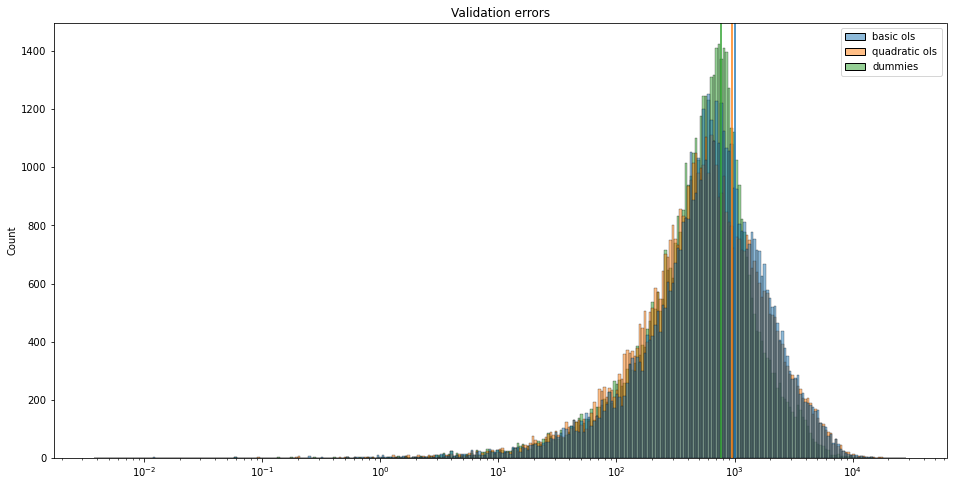

In [95]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['dummies'] = get_errors(data=df_dummies, model=pipe, exog=X, endog=y)
sns.histplot(errors, log_scale=True, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')

In [96]:
## As per Sadrach, price + 1 std: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies_trim = df_dummies[df_dummies.price <= df_dummies.price.mean() + df_dummies.price.std()]

y = ['price']
X = [col for col in df_dummies_trim.columns if col != y[0]]

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=intercept))
])

cross_val_score(estimator = pipe,
                X = df_dummies[X],
                y = df_dummies[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-773.0550338559972

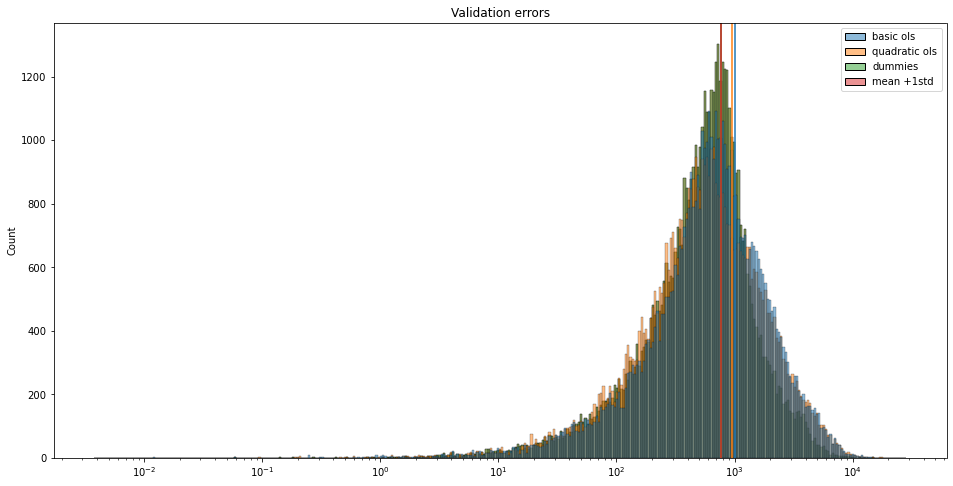

In [97]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['mean +1std'] = get_errors(data=df_dummies, model=pipe, exog=X, endog=y)
sns.histplot(errors, log_scale=True, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')

Disappointing results, dummy vars in an OLS regression likely not the best use of categorical diamond characteristics.

In [98]:
## Random forest regressor

df_rf = df.copy()
df_rf.cut = df_rf.cut.astype('category').cat.codes
df_rf.color = df_rf.color.astype('category').cat.codes
df_rf.clarity = df_rf.clarity.astype('category').cat.codes

df_rf_trim = df[df.price <= df.price.mean() + df.price.std()]

y = ['price']
X = [col for col in df_rf_trim.columns if col != y[0]]

pipe = Pipeline([
    ('fst', RandomForestRegressor(n_estimators=100, max_depth=100, random_state=1996))
])

cross_val_score(estimator = pipe,
                X = df_rf[X],
                y = df_rf[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-296.0235274742099

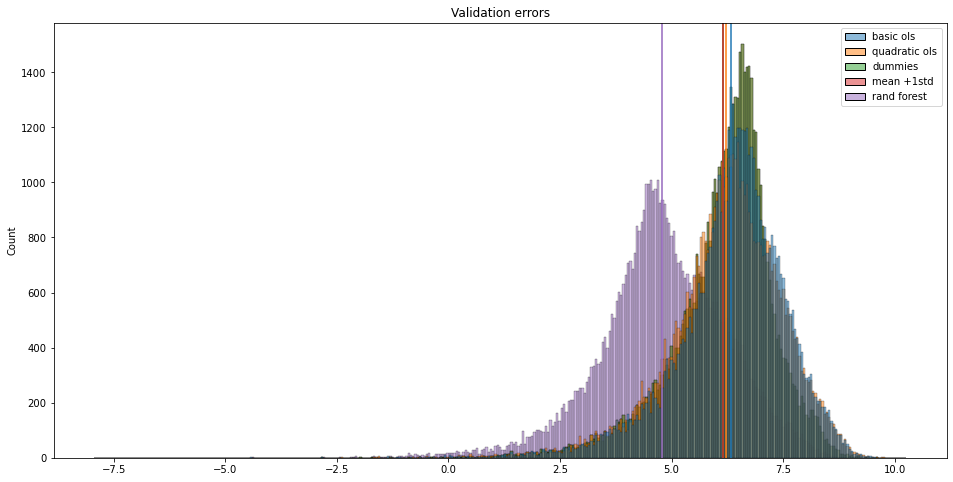

In [99]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['rand forest'] = get_errors(data=df_rf, model=pipe, exog=X, endog=y)

errors = errors.apply(np.log).replace(-np.inf, np.nan)
# ^^ apply log transformation outside of seaborn function, errors of 0 cause -inf

sns.histplot(errors[np.isfinite(errors['rand forest'])], log_scale=False, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')